<a href="https://colab.research.google.com/github/bamel-yashvander/NeuralStyleTransfer/blob/master/NeuralStyleTransfer_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Mon Aug  9 16:38:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#! mkdir images

In [3]:
#! mv content1.jpeg content2.jpg style1.jpg style2.jpg style3.jpg images/

In [4]:
import numpy as np

import torch
import torchvision

from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)

In [5]:
vgg = torchvision.models.vgg19(pretrained=True).features

In [6]:
type(vgg)

torch.nn.modules.container.Sequential

In [7]:
for parameter in vgg.parameters():
    parameter.requires_grad_(False)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [10]:
def img2tensor(path, max_size=600):
    """Preprocess the image into tensor for processing"""
    
    img = Image.open(path).convert('RGB')
    
    if max(img.size) > max_size:
        size = max_size
    else:
        size = max(img.size)
    
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])   # output = (input - mean) / std
    ])
    
    tensor = transform(img).unsqueeze(0)
    
    return tensor

In [11]:
def tensor2img(tensor):
    """Deprocess the tensor into an image for plotting"""
    
    img = tensor.to('cpu').detach().clone()
    img = img.numpy().squeeze() # shape --> (channels, height, width)
    img = img.transpose(1, 2, 0) # (c, h, w) --> (h, w, c)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = img.clip(0, 1)
    
    return img

In [12]:
def extract_features(tensor, model=vgg):
    """Extract the content and style features from the preprocessed input image (tensor)"""
    
    # "n_1" --> style layer, "n_2" --> content layer
    layers = {
        '0' : 'conv1_1',
        '5' : 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2',
        '28': 'conv5_1'
    }
    
    features = dict()
    
    for name, layer in model._modules.items():
        tensor = layer(tensor)
        
        if name in layers.keys():
            features[layers[name]] = tensor
            
    return features

In [13]:
def gram_matrix(tensor):
    b, c, h, w = tensor.size() # (batch_size, channels, height, width)
    
    tensor = tensor.view(c, -1)
    
    gram_mat = torch.mm(tensor, tensor.t())
    
    return gram_mat

In [14]:
content_tensor = img2tensor('images/content1.jpeg').to(device)
content_features = extract_features(content_tensor)

style_tensor = img2tensor('images/style2.jpg').to(device)
style_features = extract_features(style_tensor)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [15]:
# make gram matrix for every feature in style features dict
style_grams = {layer: gram_matrix(tensor) for layer, tensor in style_features.items()}

In [16]:
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

alpha = 1 
beta = 1e6

In [17]:
# clone the content tensor to target tensor and bind the target with optimizer
target = content_tensor.clone().requires_grad_(True).to(device)

optimizer = torch.optim.Adam([target], lr=3e-3)

Total Loss: 207332800.0


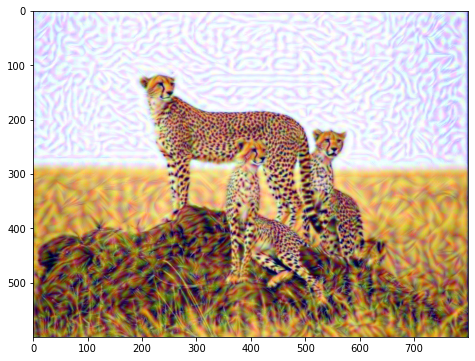

Total Loss: 96504008.0


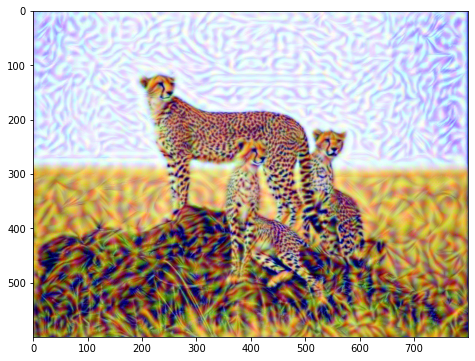

Total Loss: 54821340.0


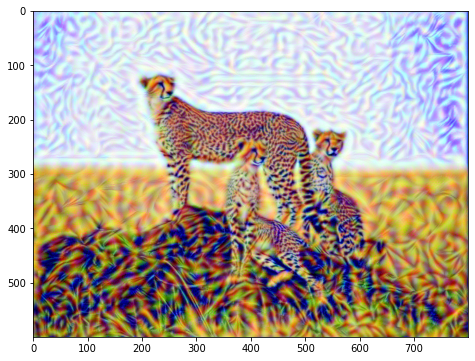

Total Loss: 35003756.0


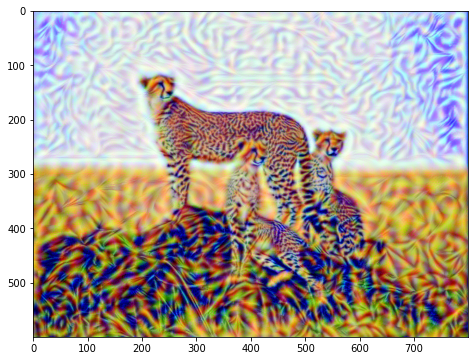

Total Loss: 24407440.0


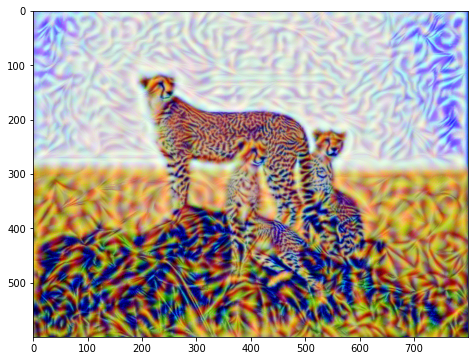

Total Loss: 17852688.0


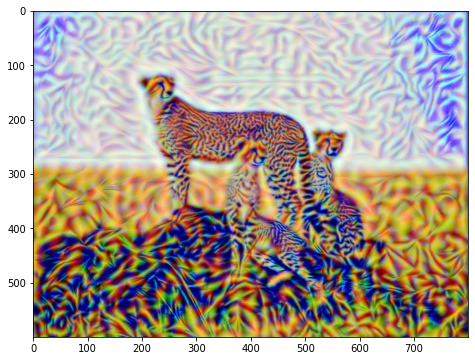

Total Loss: 13390897.0


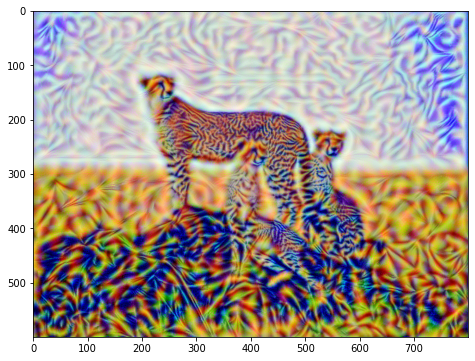

Total Loss: 10206423.0


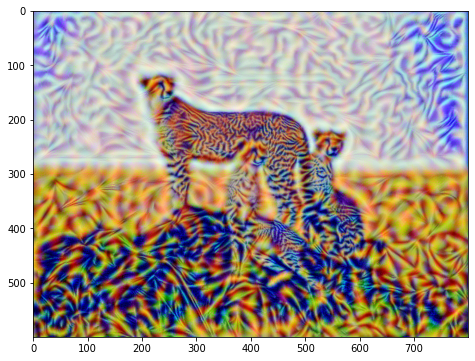

Total Loss: 7890779.0


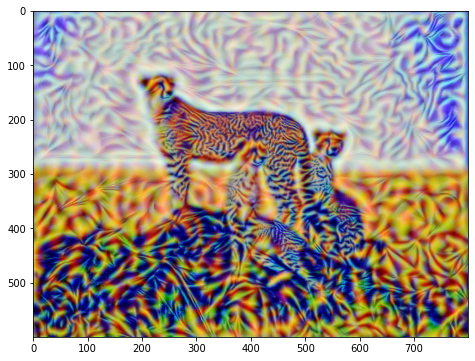

Total Loss: 6194566.5


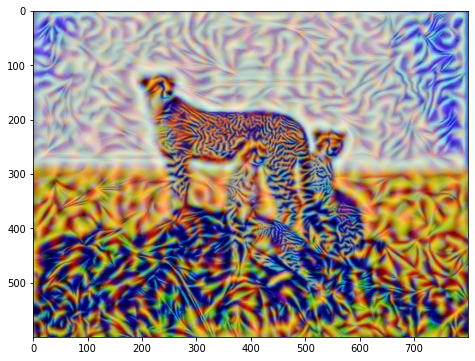

In [18]:
show_interval = 500
steps = 5000

for step in range(steps):
    target_features = extract_features(target)
    
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0
    
    for layer, weight in style_weights.items():
        target_feature = target_features[layer]
        target_gram_matrix = gram_matrix(target_feature)
        
        style_gram_matrix = style_grams[layer]
        
        b, c, h, w = target_feature.size()
        
        layer_style_loss = weight * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        style_loss += layer_style_loss / (c * h * w)
        
    total_loss = alpha * content_loss + beta * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if (step + 1) % show_interval == 0:
        print(f"Total Loss: {total_loss}")
        plt.imshow(tensor2img(target))
        plt.show()

In [19]:
i = tensor2img(target)
c = tensor2img(content_tensor)
s = tensor2img(style_tensor)

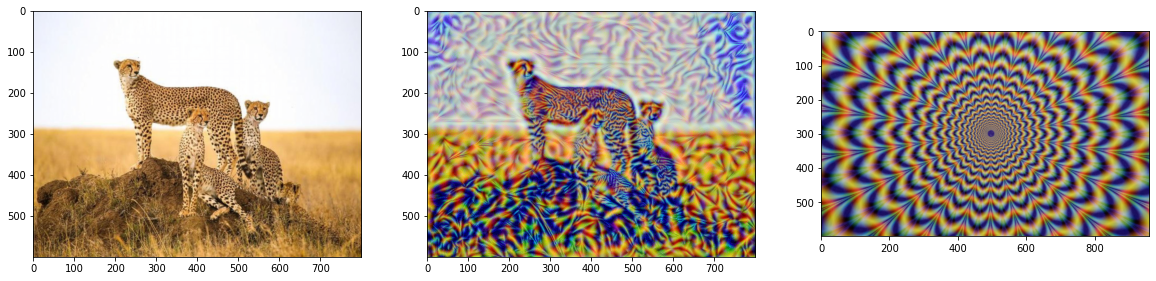

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(c)
ax2.imshow(i)
ax3.imshow(s)